In [1]:
import torch
import numpy as np
from models.training import easyTrainer, weights_to_dataset
from models.nODE import nODE, make_nODE_from_parameters
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchdiffeq import odeint
from torch.utils.data import DataLoader 
from data_creation import create_dataset, torch_parameter_structure

In [28]:
class NetworkDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,idx):
        return self.x[idx], self.y[idx]

n_data = 1

x_exact, x_train, y_train, param = create_dataset(2,n_data,1000)

trainData = NetworkDataset(x_exact,y_train)
loader = DataLoader(trainData, batch_size=64, shuffle=True)

x_test_exact, x_test, y_test, param = create_dataset(2,n_data,64)

testData = NetworkDataset(x_test_exact,y_test)
test_loader = DataLoader(testData, batch_size = 64, shuffle=True)

In [39]:
class param_classifier(torch.nn.Module):
    def __init__(self, input_size, ode_dim, layers_size=[10, 10], device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
        super().__init__()

        self.layers_size = layers_size
        self.input_size = input_size
        self.output_size = ode_dim ** 2
        self.ode_dim = ode_dim

        self.num_layers = len(layers_size) + 1
        self.device = device

        # initialise linear layers for classification block
        self.linears = torch.nn.ModuleList([torch.nn.Linear(input_size, layers_size[0]).double()])
        self.linears.extend(
            [torch.nn.Linear(layers_size[i - 1], layers_size[i]).double() for i in range(1, self.num_layers - 1)])
        self.linears.append(torch.nn.Linear(layers_size[-1], self.output_size).double())
        return
    

    def forward_integration(self, x, parameter, integration_time=None):
        if integration_time is None:
            integration_interval = torch.tensor([0., 1.]).type_as(x)
        else:
            integration_interval = torch.tensor(integration_time).type_as(x)

        par_struct = torch_parameter_structure(self.ode_dim)
        par_struct.set_vec_par(parameter)
        gamma, Win, bin, Wout, bout = par_struct.get_parameters()

        bin = bin.reshape(-1,1)*torch.ones(2,5).to(self.device)
        bout = bout.reshape(-1,1)*torch.ones(2,5).to(self.device)
        
        dt = 0.01
        out = odeint(lambda t, x : self.right_hand_side(t, x, Win, Wout, bin, bout, gamma), x, integration_interval, method='euler', options={'step_size': dt})
        return out[-1, :]
               
    def right_hand_side(self, t, x, Win,Wout,bin,bout,gamma):
        out = torch.matmul(Win.t(),x) + bin
        out = torch.matmul(Wout.t(),x) + bout
        out = gamma.reshape(-1,1)*x + out
        # out = x.matmul(Win.t()) + bin.t()
        # out = out.matmul(Wout.t()) + bout.t()
        # out = x.matmul(gamma) + out
        return out

    def get_adjacency(self,parameter):
        Win = torch.zeros(self.ode_dim,self.ode_dim).to(self.device)
        Wout = torch.zeros(self.ode_dim,self.ode_dim).to(self.device)

        k=0

        for i in range(0,self.ode_dim):
            for j in range(0,self.ode_dim):
                Win[i][j] = parameter[k]
                k += 1

        for i in range(0,self.ode_dim):
            for j in range(0,self.ode_dim):
                Wout[i][j] = parameter[k]
                k += 1
        
        A = torch.matmul(Wout,Win).flatten()
        return A

    # forward pass of NN (both classifier and neural ODE)
    def forward(self, x):
        for i in range(0, self.num_layers):
            x = self.linears[i](x)
            if i < self.num_layers-1:
                x = F.relu(x)

        # here x denote the estimated parameters for the ODE
        # x = self.linears[len(self.layers_size) - 1](x)

        return x

def loss_function(x,y):
    
    loss = 0
    # estimate parameters using classifier network
    p = classifier(x)

    for i in range(0,len(p)):
        param = p[i]

        # u0 = x[i][:2*n_data]
        # u0 = torch.reshape(u0,(n_data,2))

        # ut = y[i][:2*n_data]
        A = y[i]
        
        # # integrate ODE
        # ut_hat = classifier.forward_integration(u0.t(), param)

        # ut_hat = torch.reshape(ut_hat,(1,2*n_data))[0]
        # get adjacency matrix
        #A_hat = classifier.get_adjacency(param)

        # add to loss: error between found solution at time t and true solution
        # loss = loss + loss_fn(ut_hat.float(), ut.float())

        # add to loss: difference between estimated network and true network
        loss += loss_fn(param.float(),A.float())
        # loss = loss + 0.001*sum(abs(A_hat.flatten()))
    return loss

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ode_dim = 2

classifier = param_classifier(4*n_data+ode_dim**2, 2, layers_size=[10, 10]).to(device)
ode_dim = 2
integration_time = 1

loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

train_loss = []
test_loss = []

print(test_loader)

for epoch in range(200):

    for batch in loader:
        optimizer.zero_grad()
        

        x = batch[0].to(device)
        y = batch[1].to(device)

        # with torch.profiler.profile() as prof:
        #     loss_function(x, y, loss_fn)
        # print(prof.key_averages().table(sort_by="cuda_time_total"))
        # loss = 0
        # loss_fn = torch.nn.MSELoss()
        # loss = loss_fn(classifier(x),0*classifier(x))
        loss = loss_function(x, y)

        train_loss.append(loss)

        # backward propagation
        loss.backward()
        optimizer.step()

    with torch.no_grad():    
        for batch in test_loader:
            loss = 0

            x = batch[0].to(device)
            y = batch[1].to(device)

            loss = loss_function(x, y)

            test_loss.append(loss)

            print('Testing loss: ')
            print(loss)

Testing loss: 
tensor(21.6810, device='cuda:0')
Testing loss: 
tensor(20.6429, device='cuda:0')
Testing loss: 
tensor(19.8313, device='cuda:0')
Testing loss: 
tensor(19.1190, device='cuda:0')
Testing loss: 
tensor(18.3452, device='cuda:0')
Testing loss: 
tensor(17.5738, device='cuda:0')
Testing loss: 
tensor(16.7829, device='cuda:0')
Testing loss: 
tensor(15.9979, device='cuda:0')
Testing loss: 
tensor(15.1547, device='cuda:0')
Testing loss: 
tensor(14.3543, device='cuda:0')
Testing loss: 
tensor(13.4695, device='cuda:0')
Testing loss: 
tensor(12.6719, device='cuda:0')
Testing loss: 
tensor(11.8723, device='cuda:0')
Testing loss: 
tensor(11.0136, device='cuda:0')
Testing loss: 
tensor(10.2015, device='cuda:0')
Testing loss: 
tensor(9.4803, device='cuda:0')
Testing loss: 
tensor(8.6483, device='cuda:0')
Testing loss: 
tensor(7.8361, device='cuda:0')
Testing loss: 
tensor(7.0379, device='cuda:0')
Testing loss: 
tensor(6.2915, device='cuda:0')
Testing loss: 
tensor(5.5173, device='cuda:0'

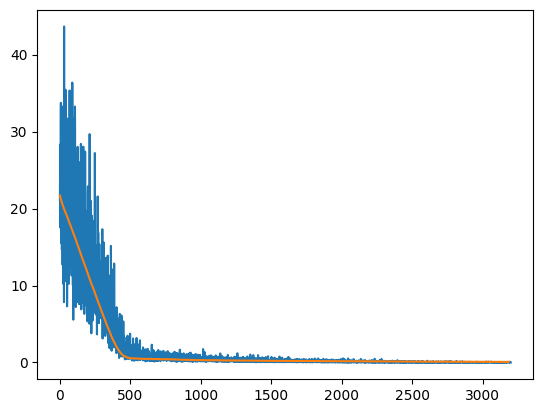

In [41]:
import matplotlib.pyplot as plt
tr_l = [train_loss[i].to('cpu').detach().numpy() for i in range(0,len(train_loss))]
tst_l = [test_loss[i].to('cpu').detach().numpy() for i in range(0,len(test_loss))]
plt.plot(range(0,len(tr_l)),tr_l)
plt.plot(range(0,len(loader)*len(tst_l),len(loader)),tst_l)
plt.show()

In [42]:
for batch in test_loader:
            loss = 0

            x = batch[0].to(device)
            y = batch[1].to(device)

            for i in range(0,len(x)):
                    inp = x[i]
                    trgt = y[i]
                    print(classifier(inp))
                    print(trgt)

            # loss = loss_function(x, y)

            # test_loss.append(loss)

            # print('Testing loss: ')
            # print(loss)

tensor([0.1133, 0.2597, 0.0009, 0.0019], device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor([0.1133, 0.2553, 0.0000, 0.0000], device='cuda:0', dtype=torch.float64)
tensor([-2.3221e-04, -5.4744e-03,  1.3152e-01, -1.3214e+00], device='cuda:0',
       dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([ 0.0000,  0.0000,  0.1357, -1.3086], device='cuda:0',
       dtype=torch.float64)
tensor([ 0.0002,  0.0015, -0.0012,  0.0008], device='cuda:0',
       dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0., 0., 0., 0.], device='cuda:0', dtype=torch.float64)
tensor([0.0003, 0.0013, 0.0005, 0.0004], device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor([0., 0., 0., 0.], device='cuda:0', dtype=torch.float64)
tensor([ 2.5147e-04,  6.1228e-04, -4.0550e-01,  3.1309e-04], device='cuda:0',
       dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([ 0.0000,  0.0000, -0.4026,  0.0000], device='cuda:0',
       dtype=torch.float64)
tensor([-1.4240e-04, 

In [ ]:
(0)